# Recover data from an image

Requirements:

- `numpy`
- `matplotlib`
- `scipy`
- `scikit-learn`
- `pillow`
- `pytsp` &mdash; use kwinkunks's fork on GitHub

I recommend installing them with `conda install`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Read the target image

In [2]:
ls data

boxer.png                                    test_f3_distorted_text.png
ceres_NASA_JPL-Caltech_UCLA_MPS_DLR_IDA.png  test_f3_rectified.png
F3_volume_3x3_16bit.npy                      test.png
fluid.png                                    tle_cover.png
Gram_Ganssle.jpg                             velocity_field.png
lisa.png


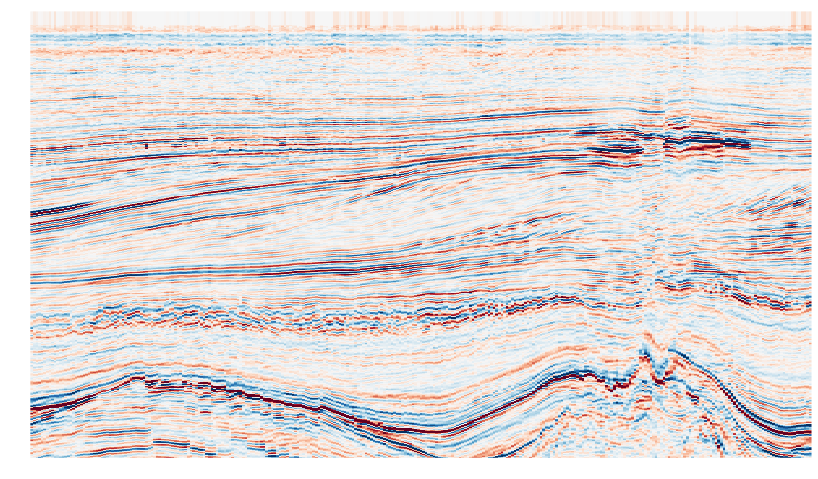

In [3]:
from PIL import Image

img = Image.open('data/test.png')

img

In [4]:
img.size

(818, 479)

## Quantize colours with `scikit`

### a) Take a sample of pixels

In [5]:
n_colours = 128

In [6]:
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [7]:
im = np.asarray(img)[:-8, 8:, :3] / 255.

h, w, d = im.shape
im_ = im.reshape((w * h, d))

# Define training set: 100 times n_colours, up to 10% of the image.
n = min(h*w//10, n_colours*100)
sample = shuffle(im_, random_state=0)[:n]
px = sample.reshape((-1, sample.shape[-1]))

Let's look at the data and plot the sample of pixels in RGB space.

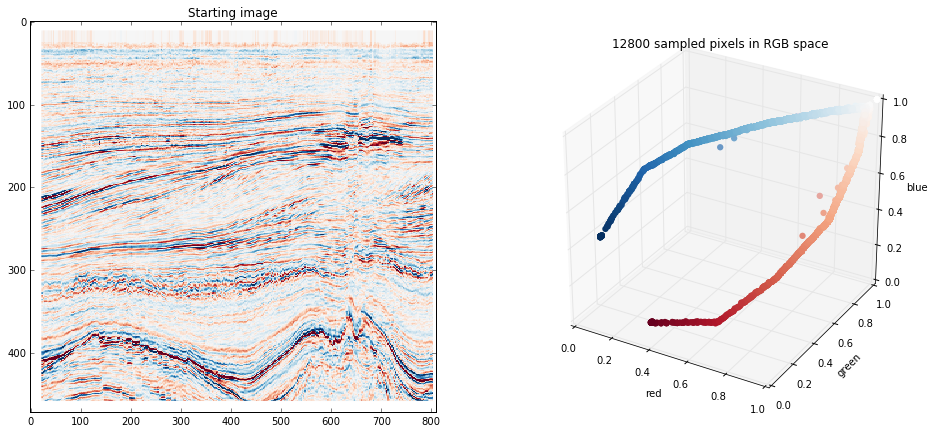

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(16, 7))

ax0 = fig.add_subplot(121)
plt.imshow(im, interpolation='none', aspect='auto')
ax0.set_title("Starting image")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*px.T, c=px, lw=0, s=40, alpha=1)
ax.set_title('{} sampled pixels in RGB space'.format(n))
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()

### b) Find the colour clusters

Instantiate and train the k-means model:

In [9]:
kmeans = KMeans(n_clusters=n_colours).fit(px)

Now I can make an RGB palette `p` — also known as a codebook in information theory terms:

In [10]:
p = kmeans.cluster_centers_

# I shouldn't need to do this, but I do. Floating point precision maybe.
p[p > 1] = 1
p[p < 0] = 0

Make sure we can recover the image:

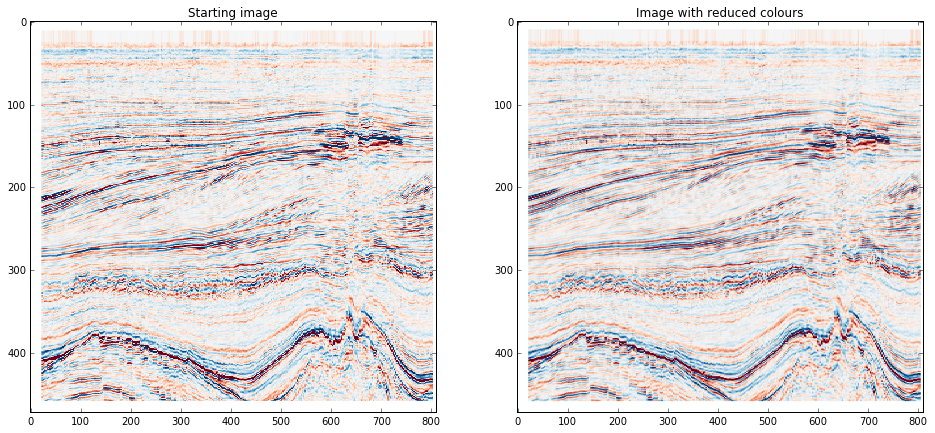

In [11]:
labels = kmeans.predict(im_)

# Set up the figure
fig = plt.figure(figsize=(16, 7))

ax0 = fig.add_subplot(121)
plt.imshow(im, interpolation='none', aspect='auto')
ax0.set_title("Starting image")

ax1 = fig.add_subplot(122)
plt.imshow(p[labels].reshape((h, w, 3)), aspect='auto')
ax1.set_title("Image with reduced colours")

plt.show()

### c) Plot new, smaller codebook in RGB space

Let's plot the colour-reduced codebook:

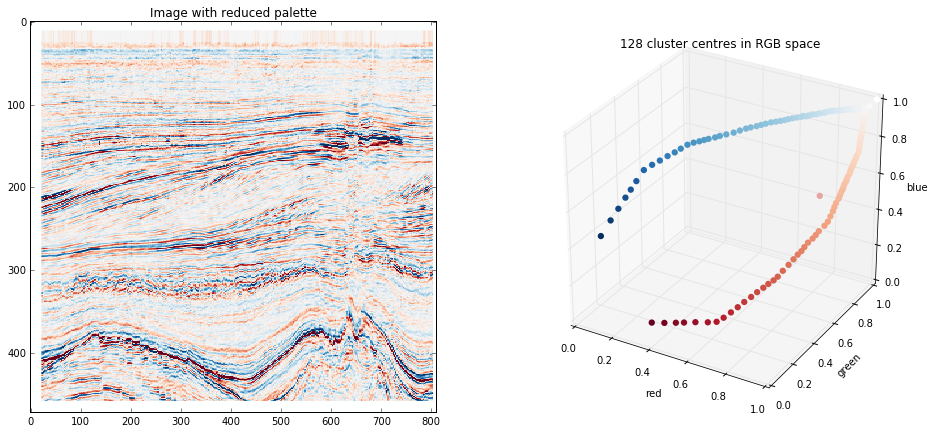

In [12]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(16, 7))

ax0 = fig.add_subplot(121)
plt.imshow(p[labels].reshape((h, w, 3)), interpolation='none', aspect='auto')
ax0.set_title("Image with reduced palette")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*p.T, c=p, lw=0, s=40, alpha=1)
ax.set_title('{} cluster centres in RGB space'.format(n_colours))
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()

The only problem with this `p` is that it is not in order — that it, there cluster centres are more or less randomly arranged. We can see this by joining up the points after plotting them.

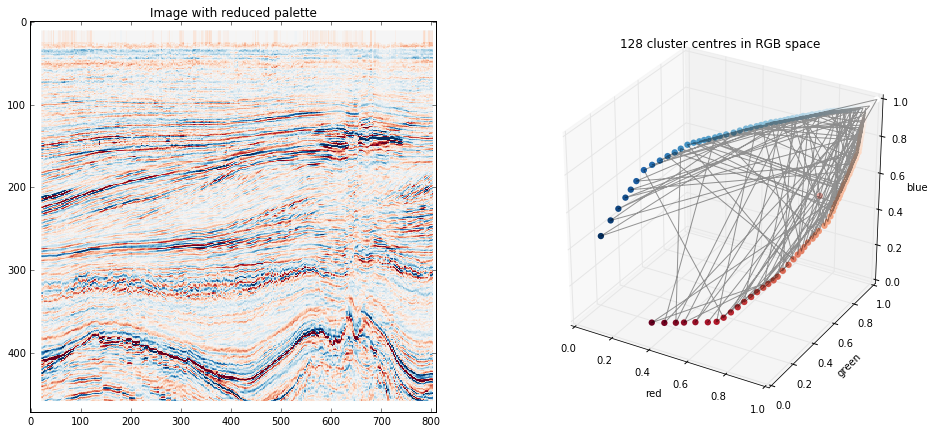

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# Set up the figure
fig = plt.figure(figsize=(16, 7))

ax0 = fig.add_subplot(121)
plt.imshow(p[labels].reshape((h, w, 3)), interpolation='none', aspect='auto')
ax0.set_title("Image with reduced palette")

ax = fig.add_subplot(122, projection='3d')
ax.scatter(*p.T, c=p, lw=0, s=40, alpha=1)
ax.plot(*p.T, color='k', alpha=0.4)
ax.set_title('{} cluster centres in RGB space'.format(n_colours))
ax.set_xlabel('red')
ax.set_ylabel('green')
ax.set_zlabel('blue')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()

## Travelling salesman problem

I propose starting at the dark end (the end of the line nearest black) and crawling aling the line of points from there. This will make a nice organized sequence of codes — in our case, this will be the colourmap.

We can solve this problem as the **travelling salesman problem**. Find the shortest tour from black (see below) to 'the other end'. I used the [LKH](http://www.akira.ruc.dk/~keld/research/LKH/) TSP solver. I call LKH via [the TSP Python package](https://github.com/perrygeo/pytsp) (use [my fork](https://github.com/kwinkunks/pytsp) in which I fixed some bugs). 

Note that you need to add the LKH libs to PATH as mentioned in the docs for `pytsp`.

LKH reference: K. Helsgaun (2009). General k-opt submoves for the Lin-Kernighan TSP heuristic. Mathematical Programming Computation, 2009, doi: 10.1007/s12532-009-0004-6.

### a) Add start point

Add a colour close to the 'start' of the colourmap (lowest values). I usually use something close to dark blue for maps: `[0,0,0]` or `[0,0,0.1]` or `[0,0,0.5]`, depending on the colourmap. For seismic data, we may want to reverse the colourmap (often dark blue is positive).

In [14]:
q = np.vstack([[[0.1, 0, 0]], p])

In [15]:
q[:6]

array([[ 0.1       ,  0.        ,  0.        ],
       [ 0.65098039,  0.07895425,  0.15947712],
       [ 0.97355072,  0.92116368,  0.89262575],
       [ 0.48235294,  0.71543052,  0.83887468],
       [ 0.97736498,  0.79098727,  0.69329205],
       [ 0.89901961,  0.51773619,  0.41229947]])

### b) Get distance matrix

To use LKH, which is a graph-based solver, we need weights for the edges of the graph — and we'll use the distances between the points. There's a convenient function, `scipy.spatial.pdist` for finding distances in *n*-space. We will use the 2-norm, but [the `pdist` function](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html) has a great many other metrics.

The convenience function `squareform` organizes the distances into a matrix.

In [16]:
from scipy.spatial.distance import pdist, squareform

# Make distance matrix.
dists = squareform(pdist(q, 'euclidean'))

# The values in `dists` are floats in the range 0 to sqrt(3). 
# Normalize the values to int16s.
d = (2**16//2 - 1) * dists / np.sqrt(3)
d = d.astype(np.int16)

In [17]:
d

array([[    0, 10953, 29359, ..., 20045, 26874, 14894],
       [10953,     0, 21987, ..., 11165, 19052,  4991],
       [29359, 21987,     0, ..., 11458,  3304, 17408],
       ..., 
       [20045, 11165, 11458, ...,     0,  8252,  6241],
       [26874, 19052,  3304, ...,  8252,     0, 14335],
       [14894,  4991, 17408, ...,  6241, 14335,     0]], dtype=int16)

### c) Add an 'everywhere' point

This trick to find a Hamiltonian path instead of a Hamiltonian circuit is legit, I promise. [Reference](http://stackoverflow.com/questions/6733999/what-is-the-problem-name-for-traveling-salesman-problemtsp-without-considering) from E. L. Lawler, Jan Karel Lenstra, A. H. G. Rinnooy Kan, D. B. Shmoys (1985). The Traveling Salesman Problem: A Guided Tour of Combinatorial Optimization, 1st Edition. Wiley. 476 pp. ISBN 978-0471904137.

In [18]:
# To use a TSP algo to solve the shortest Hamiltonian path problem,
# we need to add a point that is zero units from every other point.
row, col = dists.shape
d = np.insert(d, row, 0, axis=0)
d = np.insert(d, col, 0, axis=1)

d

array([[    0, 10953, 29359, ..., 26874, 14894,     0],
       [10953,     0, 21987, ..., 19052,  4991,     0],
       [29359, 21987,     0, ...,  3304, 17408,     0],
       ..., 
       [26874, 19052,  3304, ...,     0, 14335,     0],
       [14894,  4991, 17408, ..., 14335,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int16)

### d) Run the solver

In [19]:
from pytsp import run, dumps_matrix

In [20]:
outf = "/tmp/myroute_lkh.tsp"
with open(outf, 'w') as f:
    f.write(dumps_matrix(d, name="My Route"))

In [21]:
tour_lkh = run(outf, start=0, solver="LKH")

In [22]:
result = np.array(tour_lkh['tour'])

In [23]:
result

array([  0,  17,  97,  39, 109,  58,   1,  72, 105,  43, 124,  83,  19,
       128,  46,  84,  16, 108,  50,  71,  28,  60,  78,   5, 126,  68,
        31,  88,  48,  81,  10, 114,  76,  41, 106, 123,  18, 119, 116,
        54, 118,  33,  85, 121,   4,  94,  63, 120,  36, 127, 101,  34,
        64,  11,  86,  51,  22, 111,  55,  91,  44, 113,   2,  89,  52,
        32,  92,   9,  87,  98,  15,  35,  69,  57, 125,  20,  80,  47,
       102,  67,   6,  95,  42,  77,  24,  62,  99,  21,  59,   8,  90,
        61, 107,  26, 122,  45,  49, 110,  13,  82,  38,  79, 100,  29,
        73, 112,   3,  66,  23, 103,  30,  96,  53, 117,  14, 115,  70,
        40,  75,  27,  74,   7, 104,  37,  93,  56,  25,  65,  12, 129])

### e) Remove the extra points we added

The 'everywhere' point, with the highest index, should be at the end. If it isn't try changing the 'cool' or 'zero' point that we added. I usually use `[0,0,0]` or `[0,0,0.1]` or `[0,0,0.5]`, depending on the colourmap. 

In [24]:
assert result.size == n_colours + 2

In [25]:
e = np.asscalar(np.where(result == result.size-1)[0])

if e == 1:
    # Then it's second and I think I know why.
    # As long as it went to the last point next, and I think
    # it necessarily does, then we're good.
    print("Zero-point is second. Probably dealt with it.")
    result = np.concatenate([result[:e], result[e+1::][::-1]])
elif e == len(result)-1:
    # Then it's at the end already.
    print("Zero-point is at the end. Dealt with it.")
    result = result[:-1]
else:
    # I'm not sure why this would happen... but I Think in this
    # case we can just skip it.
    print("Zero-point is somewhere weird. Maybe dealt with... BE CAREFUL. This probably won't work.")
    result = result[result != result.size-1]

assert len(result) == len(q)

# Remove the 'zero' or 'cool' point.
r = result[1:]

Zero-point is at the end. Dealt with it.


### f) Get the colour table

Now we can select the points easily for an ordered colourmap.

In [26]:
c = q[r]

### g) Look at the path

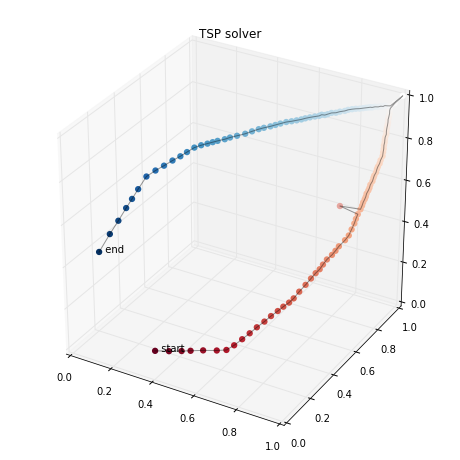

In [27]:
from mpl_toolkits.mplot3d import Axes3D
# Set up the figure
fig = plt.figure(figsize=(8, 8))

# Result of TSP solver
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax.plot(*c.T, color='k', alpha=0.4)
ax.text(*c[0], '  start')
ax.text(*c[-1], '  end')
ax.set_title('TSP solver')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)

plt.show()

## Make the data space

We need to make a 'data space' --- the range of numbers we want the colours to represent. For this, we need the distances from each point to the next.

In [35]:
dataspace = np.concatenate([[0], np.cumsum([d[p, q] for p, q in zip(r, r[1:])])])

In [29]:
# Normalize to [0, 1]
dataspace = dataspace/np.max(dataspace)

In [30]:
dataspace

array([ 0.        ,  0.01788376,  0.03411695,  0.04568691,  0.06174383,
        0.07914684,  0.09137381,  0.1025111 ,  0.11517074,  0.12722145,
        0.13903178,  0.15097031,  0.16191529,  0.17260388,  0.18157781,
        0.19061584,  0.19843597,  0.20931686,  0.22098297,  0.23146323,
        0.24037306,  0.24740798,  0.2544429 ,  0.26261558,  0.27117286,
        0.27799946,  0.28506642,  0.29601141,  0.30357515,  0.31192411,
        0.31998462,  0.32610612,  0.33233979,  0.35903723,  0.38725702,
        0.39225678,  0.39650337,  0.40095829,  0.40438761,  0.40840985,
        0.41281669,  0.41635819,  0.42047658,  0.42565261,  0.42999535,
        0.43307213,  0.43759114,  0.44175761,  0.44515488,  0.44962582,
        0.45390446,  0.45970546,  0.4646251 ,  0.46885566,  0.47318238,
        0.47701232,  0.48053779,  0.48358252,  0.48739644,  0.49143471,
        0.49532875,  0.4988382 ,  0.50255597,  0.50585709,  0.50914219,
        0.51364518,  0.51744307,  0.52024742,  0.52851626,  0.54

For some data images, we may want to do this instead:

In [31]:
# dataspace = np.arange(0, len(c))

## Recover the data

In [32]:
from scipy.spatial import KDTree, cKDTree

kdtree = cKDTree(c)

In [33]:
dx, ix = kdtree.query(im)

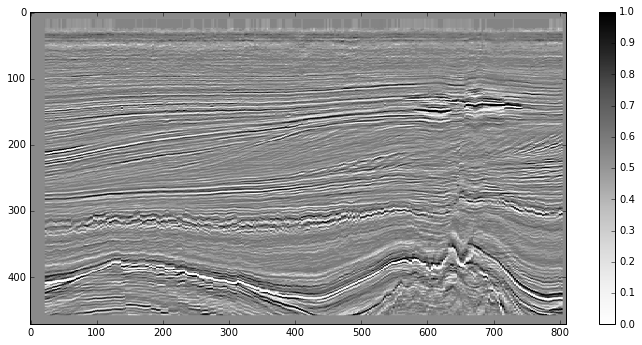

In [34]:
plt.figure(figsize=(12,8))
plt.imshow(dataspace[ix], cmap='Greys')
plt.colorbar(shrink=0.7)
plt.show()

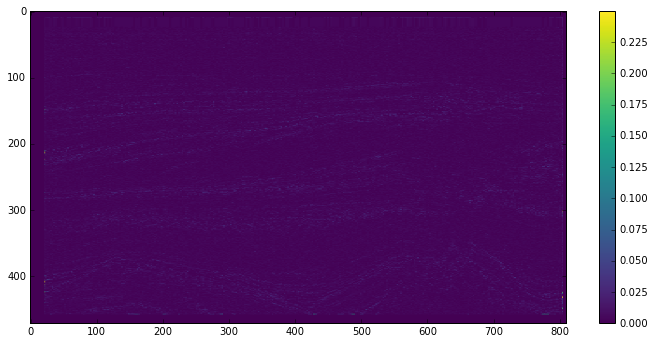

In [36]:
plt.figure(figsize=(12,8))
plt.imshow(dx, cmap='viridis')
plt.colorbar(shrink=0.7)
plt.show()

## Test against the original image

In [37]:
recovered = dataspace[ix].astype(np.float)
recovered -= np.mean(dataspace[ix])
recovered /= max(np.amax(recovered), np.abs(np.amin(recovered)))

In [38]:
z_out = dataspace[ix].astype(np.float)
z_out /= np.amax(z_out)

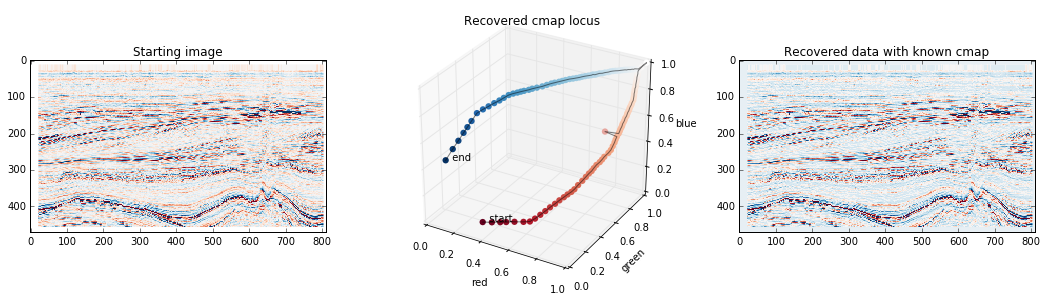

In [39]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(131)
plt.imshow(im, interpolation='none')
ax0.set_title("Starting image")

ax1 = fig.add_subplot(132, projection='3d')
ax1.scatter(*c.T, c=c, lw=0, s=40, alpha=1)
ax1.plot(*c.T, color='k', alpha=0.5)
ax1.text(*c[0], '  start')
ax1.text(*c[-1], '  end')
ax1.set_title("Recovered cmap locus")
ax1.set_xlabel('red')
ax1.set_ylabel('green')
ax1.set_zlabel('blue')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_zlim(0, 1)

ax2 = fig.add_subplot(133)
plt.imshow(recovered, cmap='RdBu', interpolation='none')
#plt.colorbar(shrink=0.75)
ax2.set_title("Recovered data with known cmap")

plt.show()

## Recover the colourbar

As a bonus, we can recover the colourbar too.

In [40]:
# setting up color arrays
r1 = np.array(c)[:, 0] # value of Red for the nth sample
g1 = np.array(c)[:, 1] # value of Green for the nth sample
b1 = np.array(c)[:, 2] # value of Blue for the nth sample

r2 = r1 # value of Red at the nth sample
r0 = np.linspace(0, 1, len(r1)) # position of the nth Red sample within the range 0 to 1

g2 = g1 # value of Green at the nth sample
g0 = np.linspace(0, 1, len(g1)) # position of the nth Green sample within the range 0 to 1

b2 = b1 # value of Blue at the nth sample
b0 = np.linspace(0, 1, len(b1)) # position of the nth Blue sample within the range 0 to 1

# creating lists
R = zip(r0, r1, r2)
G = zip(g0, g1, g2)
B = zip(b0, b1, b2)

# creating list of above lists and transposing
RGB = zip(R, G, B)
rgb = zip(*RGB)
#print rgb

# creating dictionary
k = ['red', 'green', 'blue'] # makes list of keys
data_dict = dict(zip(k,rgb)) # makes a dictionary from list of keys and list of values

# Make a colourbar
import matplotlib.colors as clr

found_cmap = clr.LinearSegmentedColormap('my_colourmap', data_dict)

If we render the found data with the found colorbar, it will look perfect, because the colourbar is the codebook that maps the data to the original image.

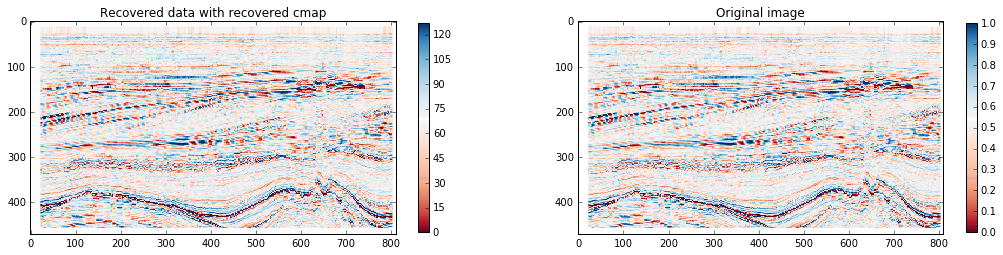

In [41]:
fig = plt.figure(figsize=(18, 5))

ax0 = fig.add_subplot(121)
plt.imshow(ix, cmap=found_cmap, interpolation='none')
plt.colorbar(shrink=0.75)
ax0.set_title("Recovered data with recovered cmap")

ax1 = fig.add_subplot(122)
plt.imshow(im, cmap=found_cmap, interpolation='none')
plt.colorbar(shrink=0.75)
ax1.set_title("Original image")

plt.show()